## 1. Setup

In [1]:
!pip install -q mplfinance
!pip install -q ta

## 2. Load & Sanity

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls -al /content/drive/MyDrive/IS_Safem0de

total 1416
drwx------ 2 root root    4096 Nov  3 04:15 colab
drwx------ 2 root root    4096 Nov  3 03:28 data
-rw------- 1 root root 1433206 Oct 16 03:59 EURUSD_H4.csv
drwx------ 2 root root    4096 Nov  3 02:47 paper
drwx------ 2 root root    4096 Nov  3 02:48 prelim_midterm


In [4]:
data_path = '/content/drive/MyDrive/IS_Safem0de/EURUSD_H4.csv'

In [5]:
import pandas as pd

df = pd.read_csv(data_path)
df.tail()

,2009-10-05 20:00,1.46469,1.46609,1.46436,1.46558,2247
25842,2025-10-15 08:00,1.16355,1.16453,1.16195,1.16199,16243
25843,2025-10-15 12:00,1.16201,1.16472,1.16103,1.16369,25939
25844,2025-10-15 16:00,1.16371,1.16448,1.16269,1.16441,14745
25845,2025-10-15 20:00,1.16442,1.16519,1.16418,1.16456,5554
25846,2025-10-16 00:00,1.16455,1.16754,1.16425,1.16659,14450


In [6]:
# ตรวจชื่อคอลัมน์
df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

# แปลง datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# ตั้ง index เป็นเวลา (สะดวกกับการ plot)
df.set_index('datetime', inplace=True)

print(df.index.min(), df.index.max(), len(df))
df.head()

2009-10-06 00:00:00 2025-10-16 00:00:00 25847


,open,high,low,close,volume
datetime,,,,,
2009-10-06 00:00:00,1.46563,1.47178,1.46541,1.47035,10300
2009-10-06 04:00:00,1.47051,1.47486,1.46951,1.47169,12566
2009-10-06 08:00:00,1.47176,1.47458,1.47068,1.47264,18816
2009-10-06 12:00:00,1.47270,1.47612,1.46951,1.47416,15619
2009-10-06 16:00:00,1.47409,1.47537,1.47023,1.47160,13948


In [7]:
from ta.volatility import AverageTrueRange
import numpy as np

# returns & log-returns
df['ret_1'] = df['close'].pct_change()
df['logret_1'] = np.log(df['close']).diff()

# ATR เป็นฐาน stop/TP
atr_n = 14
atr = AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=atr_n)
df['atr'] = atr.average_true_range()

# regime-ish (ง่ายๆ)
df['ema_fast'] = df['close'].ewm(span=20).mean()
df['ema_slow'] = df['close'].ewm(span=50).mean()
df['trend_up'] = (df['ema_fast'] > df['ema_slow']).astype(int)
df['vol_z'] = (df['logret_1'].rolling(50).std() / df['logret_1'].rolling(200).std())

df.tail()

,open,high,low,close,volume,ret_1,logret_1,atr,ema_fast,ema_slow,trend_up,vol_z
datetime,,,,,,,,,,,,
2025-10-15 08:00:00,1.16355,1.16453,1.16195,1.16199,16243,-0.001349,-0.001350,0.002738,1.160077,1.162636,0,1.197292
2025-10-15 12:00:00,1.16201,1.16472,1.16103,1.16369,25939,0.001463,0.001462,0.002806,1.160421,1.162678,0,1.201422
2025-10-15 16:00:00,1.16371,1.16448,1.16269,1.16441,14745,0.000619,0.000619,0.002734,1.160801,1.162746,0,1.203829
2025-10-15 20:00:00,1.16442,1.16519,1.16418,1.16456,5554,0.000129,0.000129,0.002611,1.161159,1.162817,0,1.205963
2025-10-16 00:00:00,1.16455,1.16754,1.16425,1.16659,14450,0.001743,0.001742,0.002659,1.161676,1.162965,0,1.199740


In [8]:
def sanity_checks(df):
    problems = []
    if not df.index.is_monotonic_increasing:
        problems.append("index not monotonic")
    if df.index.duplicated().any():
        problems.append("duplicate timestamps")
    # ฟีเจอร์ที่ต้องไม่มี NaN ณ จุดเข้า
    needed = ['atr','ema_fast','ema_slow','vol_z','open','high','low','close']
    miss = [c for c in needed if c not in df.columns]
    if miss: problems.append(f"missing columns: {miss}")
    # ตรวจว่า entry ใช้ข้อมูลแท่งเดียวกัน: ถ้าต้องการ 'เข้าเปิดแท่งถัดไป' ให้ shift(1)
    # แสดงคำแนะนำ ไม่บังคับ
    return problems

problems = sanity_checks(df)
print("Sanity:", "OK" if not problems else problems)

Sanity: OK


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# กัน NaN ต้นซีรีส์สำหรับ ATR/EMA
df = df.copy()
df = df.dropna(subset=['open','high','low','close'])

# ถ้าคอลัมน์เหล่านี้ยังไม่มี ให้ข้ามฟังก์ชันวาดชิ้นนั้น
def _has(cols):
    return all(c in df.columns for c in cols)

In [10]:
def _pick_cols(df, base_names):
    """
    base_names: {'pivot':'pivot', 'pivot_price':'pivot_price', 'swing_dir':'swing_dir'}
    return: mapping ของชื่อจริงใน df (เช่น {'pivot':'zz_pivot', ...})
    """
    out = {}
    for k, base in base_names.items():
        if base in df.columns:
            out[k] = base
        elif f'zz_{base}' in df.columns:
            out[k] = f'zz_{base}'
        else:
            raise KeyError(f"missing column for '{base}' (tried '{base}', 'zz_{base}')")
    return out


In [11]:
def ensure_zigzag(df, pct=0.004):
    need_any = {'pivot','zz_pivot'}
    if not (need_any & set(df.columns)):
        # ไม่มี zigzag เลย → คำนวณใหม่แบบมี prefix กันชน
        zz = zigzag_online(df['close'], pct=pct).add_prefix('zz_')
        df = df.join(zz)
    return df

In [12]:
def plot_zigzag_zoom(df, start=None, end=None, title='ZigZag (confirmed pivots)'):
    df = ensure_zigzag(df, pct=0.004)  # เผื่อยังไม่ได้คำนวณ
    cols = _pick_cols(df, {'pivot':'pivot','pivot_price':'pivot_price','swing_dir':'swing_dir'})

    d = take_range(df, start, end)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,4))
    plt.plot(d.index, d['close'], label='close')

    piv = d[d[cols['pivot']] != 0]
    if piv.empty:
        plt.title(title + " — no pivots in this window")
        plt.xlabel('time'); plt.ylabel('price'); plt.legend(); plt.tight_layout(); plt.show()
        return

    # จุด pivot + เส้นเชื่อม
    plt.scatter(piv.index, piv[cols['pivot_price']], marker='o', label='pivot')
    prev_t = None; prev_p = None
    for t, p in zip(piv.index, piv[cols['pivot_price']]):
        if prev_t is not None:
            plt.plot([prev_t, t], [prev_p, p])
        prev_t, prev_p = t, p

    plt.title(title); plt.xlabel('time'); plt.ylabel('price'); plt.legend(); plt.tight_layout(); plt.show()

In [13]:
import pandas as pd

def take_range(d, start=None, end=None):
    if start is None and end is None:
        # default = 6 เดือนล่าสุด (อ่านง่าย)
        end = d.index.max()
        start = end - pd.Timedelta(days=180)
    return d.loc[str(start):str(end)]

def thin(df, every=3):
    """เอาทุก n จุด เพื่อลดความแน่น (กราฟอ่านง่ายขึ้น)"""
    return df.iloc[::every].copy()

In [14]:
import matplotlib.pyplot as plt

def plot_close_with_emas_zoom(df, start=None, end=None, every=1, title='Close + EMA(20/50)'):
    d = take_range(df, start, end)
    d = thin(d, every)
    plt.figure(figsize=(12,4))
    plt.plot(d.index, d['close'], label='close')
    plt.plot(d.index, d['ema_fast'], label='ema20')
    plt.plot(d.index, d['ema_slow'], label='ema50')
    plt.title(title); plt.xlabel('time'); plt.ylabel('price'); plt.legend(); plt.tight_layout(); plt.show()


In [15]:
def plot_atr_zoom(df, start=None, end=None, every=1, title='ATR(14)'):
    d = take_range(df, start, end)
    d = thin(d, every)
    plt.figure(figsize=(12,2.8))
    plt.plot(d.index, d['atr'], label='ATR')
    plt.title(title); plt.xlabel('time'); plt.ylabel('ATR'); plt.legend(); plt.tight_layout(); plt.show()


In [16]:
def plot_trend_flag_zoom(df, start=None, end=None, every=1, title='Trend Up (1/0)'):
    d = take_range(df, start, end)
    d = thin(d, every)
    plt.figure(figsize=(12,2.6))
    plt.step(d.index, d['trend_up'], where='post', label='trend_up')
    plt.ylim(-0.2, 1.2)
    plt.title(title); plt.xlabel('time'); plt.ylabel('flag'); plt.legend(); plt.tight_layout(); plt.show()


In [17]:
def plot_volz_zoom(df, start=None, end=None, every=1, smooth=20, title='Volatility Z (50/200)'):
    d = take_range(df, start, end)
    d = thin(d, every)
    v = d['vol_z'].rolling(smooth, min_periods=1).mean()
    plt.figure(figsize=(12,2.8))
    plt.plot(d.index, v, label=f'vol_z (ma{smooth})')
    plt.axhline(1.0)  # เส้นอ้างอิง 1 = vol50 ใกล้ vol200
    plt.title(title); plt.xlabel('time'); plt.ylabel('ratio'); plt.legend(); plt.tight_layout(); plt.show()


In [30]:
# --- helper: เลือกชื่อคอลัมน์ zigzag ที่มีอยู่จริง ---
def _zz_cols(d):
    cand = [
        ('zz_pivot', 'zz_pivot_price', 'zz_swing_dir'),
        ('pivot',    'pivot_price',    'swing_dir'),
    ]
    for p, pp, s in cand:
        if p in d.columns and pp in d.columns:
            return p, pp, (s if s in d.columns else None)
    raise KeyError("No zigzag columns found (expect zz_pivot/zz_pivot_price or pivot/pivot_price).")

# --- helper: ตัดช่วงเวลาแบบปลอดภัย ---
def take_range(df, start=None, end=None):
    if start is None and end is None:
        return df
    return df.loc[str(start):str(end)].copy()

# --- fixed: zigzag plot ---
import matplotlib.pyplot as plt

def plot_zigzag_zoom(df, start=None, end=None, title='ZigZag (confirmed pivots)'):
    d = take_range(df, start, end)
    pcol, pprice, _ = _zz_cols(d)

    plt.figure(figsize=(12,4))
    plt.plot(d.index, d['close'], label='close')

    piv = d.loc[d[pcol] != 0].copy()
    piv = piv[pprice].dropna()
    if not piv.empty:
        plt.scatter(piv.index, piv.values, marker='o', label='pivot')

        # เชื่อมเส้นระหว่าง pivot ทีละจุด
        prev_t, prev_p = None, None
        for t, p in piv.items():
            if prev_t is not None:
                plt.plot([prev_t, t], [prev_p, p])
            prev_t, prev_p = t, p

    plt.title(title); plt.xlabel('time'); plt.ylabel('price')
    plt.legend(); plt.tight_layout(); plt.show()

In [19]:
import mplfinance as mpf

def plot_candles_with_patterns_zoom(df, start=None, end=None, title='Candles + Patterns'):
    d = take_range(df, start, end)
    if d.empty:
        print("No data in range"); return

    mpf.plot(d[['open','high','low','close']], type='candle', style='charles',
             title=title, volume=False)

    fig = plt.gcf(); ax = plt.gca()
    y = d['close']

    if 'bull_engulf' in d:
        m = d['bull_engulf']==1; ax.scatter(d.index[m], y[m], marker='^', label='bull_engulf')
    if 'bear_engulf' in d:
        m = d['bear_engulf']==1; ax.scatter(d.index[m], y[m], marker='v', label='bear_engulf')
    if 'inside_bar' in d:
        m = d['inside_bar']==1; ax.scatter(d.index[m], y[m], marker='s', label='inside_bar')
    if 'pin_bull' in d:
        m = d['pin_bull']==1; ax.scatter(d.index[m], y[m], marker='P', label='pin_bull')
    if 'pin_bear' in d:
        m = d['pin_bear']==1; ax.scatter(d.index[m], y[m], marker='X', label='pin_bear')

    ax.legend(loc='best'); fig.tight_layout(); plt.show()


In [20]:
import numpy as np
import pandas as pd
import mplfinance as mpf

def plot_candles_patterns_zigzag(df, start=None, end=None,
                                 title='Candles + Patterns + ZigZag (combined)',
                                 markersize=70):
    # 1) เลือกช่วง (ดีฟอลต์ 60 วันล่าสุด)
    if start is None and end is None:
        end = df.index.max()
        start = end - pd.Timedelta(days=60)
    d = df.loc[str(start):str(end)].copy()
    if d.empty:
        print("No data in range"); return

    # 2) เตรียม addplots สำหรับแต่ละแพทเทิร์น (NaN = ไม่วาด)
    ap = []
    def patt(col, marker):
        if col in d.columns:
            y = d['close'].where(d[col] == 1, np.nan)
            ap.append(mpf.make_addplot(y, type='scatter', marker=marker, markersize=markersize))

    patt('bull_engulf','^')
    patt('bear_engulf','v')
    patt('inside_bar','s')
    patt('pin_bull','P')
    patt('pin_bear','X')

    # 3) เตรียมเส้น ZigZag (ถ้ามีคอลัมน์)
    pivot_col = 'pivot' if 'pivot' in d.columns else ('zz_pivot' if 'zz_pivot' in d.columns else None)
    pp_col    = 'pivot_price' if 'pivot_price' in d.columns else ('zz_pivot_price' if 'zz_pivot_price' in d.columns else None)

    alines_dict = None
    if pivot_col and pp_col:
        piv = d[d[pivot_col] != 0][[pp_col]]
        if not piv.empty:
            lines = []
            pts = list(zip(piv.index, piv[pp_col].values))
            for (t0, y0), (t1, y1) in zip(pts[:-1], pts[1:]):
                lines.append([(t0, y0), (t1, y1)])
            alines_dict = dict(alines=lines, linewidths=1)

            # ตำแหน่งจุด pivot เองให้เห็นชัด (วงกลมเล็ก ๆ)
            piv_y = d[pp_col].where(d[pivot_col] != 0, np.nan)
            ap.append(mpf.make_addplot(piv_y, type='scatter', marker='o', markersize=30))

    # 4) วาดกราฟเดียวครบชุด
    mpf.plot(
        d[['open','high','low','close']],
        type='candle',
        style='charles',
        title=title,
        volume=False,
        addplot=ap,
        alines=alines_dict,
        figsize=(10,6)
    )


## 3. ZigZag

In [21]:
def zigzag_online(prices, pct=0.004, atr=None, atr_mult=None):
    """
    prices: pd.Series (close)
    pct:   สัดส่วนเบี่ยงเบนขั้นต่ำจาก extreme (ถ้าไม่ใช้ ATR)
    atr, atr_mult: ถ้าอยากใช้เกณฑ์ ATR (เช่น atr_mult=2.0)
    return: DataFrame columns: pivot, pivot_price, direction
            direction:  1=up swing, -1=down swing, 0=undefined (เริ่มต้น)
    """
    pivots = np.zeros(len(prices), dtype=np.int8)
    pivot_price = np.full(len(prices), np.nan)
    direction = np.zeros(len(prices), dtype=np.int8)

    last_pivot_idx = 0
    last_pivot_price = prices.iloc[0]
    trend = 0  # 1 up, -1 down, 0 unknown
    extreme_price = last_pivot_price

    def crossed(from_price, to_price, ref_idx):
        if atr is not None and atr_mult is not None:
            thr = atr.iloc[ref_idx] * atr_mult
            return abs(to_price - from_price) >= thr
        else:
            return abs(to_price/from_price - 1.0) >= pct

    for i in range(1, len(prices)):
        p = prices.iloc[i]
        if trend == 0:
            # ยังไม่รู้ทิศ จนกว่าจะเบี่ยงจาก last_pivot เกิน threshold
            if crossed(last_pivot_price, p, i):
                trend = 1 if p > last_pivot_price else -1
                extreme_price = p
        elif trend == 1:
            # ขาขึ้น: อัปเดต high ต่อเนื่อง ถ้าราคากลับตัวลงเกิน threshold => ยืนยัน pivot high
            if p > extreme_price:
                extreme_price = p
            elif crossed(extreme_price, p, i):
                # confirm pivot high ที่ตำแหน่งของ extreme ล่าสุด
                pivots[i-1] = 1
                pivot_price[i-1] = extreme_price
                direction[i-1] = 1
                last_pivot_idx = i-1
                last_pivot_price = extreme_price
                trend = -1
                extreme_price = p
        else:  # trend == -1
            # ขาลง: อัปเดต low ต่อเนื่อง ถ้าราคากลับตัวขึ้นเกิน threshold => ยืนยัน pivot low
            if p < extreme_price:
                extreme_price = p
            elif crossed(extreme_price, p, i):
                pivots[i-1] = -1
                pivot_price[i-1] = extreme_price
                direction[i-1] = -1
                last_pivot_idx = i-1
                last_pivot_price = extreme_price
                trend = 1
                extreme_price = p

    out = pd.DataFrame({
        'pivot': pivots,
        'pivot_price': pivot_price,
        'swing_dir': direction
    }, index=prices.index)
    return out

# ใช้แบบเปอร์เซ็นต์ (เช่น 0.4%)
zz = zigzag_online(df['close'], pct=0.004).add_prefix('zz_')
df = df.join(zz)   # ตอนนี้ไม่มีชื่อชนแล้ว

# อย่าลืมแก้ชื่อคอลัมน์ตอนทำฟีเจอร์
df['is_pivot_high'] = (df['zz_pivot'] == 1).astype(int)
df['is_pivot_low']  = (df['zz_pivot'] == -1).astype(int)

s = df['zz_swing_dir']
df['last_swing_dir'] = (
    s.where(s != 0, np.nan).ffill().fillna(0).astype('int8')
)


## 4. Candlestick Patterns

In [22]:
def body(o,c): return abs(c-o)
def range_(h,l): return (h-l)

# Engulfing
df['bull_engulf'] = (((df['close']>df['open']) & (df['close'].shift(1)<df['open'].shift(1)) &
                      (df['close']>=df['open'].shift(1)) & (df['open']<=df['close'].shift(1))).astype(int))

df['bear_engulf'] = (((df['close']<df['open']) & (df['close'].shift(1)>df['open'].shift(1)) &
                      (df['close']<=df['open'].shift(1)) & (df['open']>=df['close'].shift(1))).astype(int))

# Inside bar
df['inside_bar'] = (((df['high']<=df['high'].shift(1)) & (df['low']>=df['low'].shift(1))).astype(int))

# Pin-bar (หางยาวกว่า body หลายเท่า)
ratio = 2.5
df['pin_bull'] = ((((df['high']-df['close']) < body(df['open'], df['close']))) &
                  (((df['open']-df['low']) > ratio*body(df['open'], df['close'])))).astype(int)
df['pin_bear'] = ((((df['close']-df['low']) < body(df['open'], df['close']))) &
                  (((df['high']-df['open']) > ratio*body(df['open'], df['close'])))).astype(int)

# Context: เกิดใกล้ pivot?
df['near_pivot_high'] = (df['is_pivot_high'].rolling(3).max()>0).astype(int)
df['near_pivot_low']  = (df['is_pivot_low'].rolling(3).max()>0).astype(int)

## 5. Outcome Engine

In [23]:
def make_trade_outcome(df, side, atr_mult=1.5, rr=1.5, k=12):
    """
    side: 'long' หรือ 'short'
    คืนค่า: tp_hit, sl_hit, outcome (1=ชนะ, 0=แพ้, -1=ไม่เกิดอะไรในกรอบ), rr_realized
    """
    close = df['close'].values
    atr = df['atr'].values
    n = len(df)
    tp_hit = np.zeros(n, dtype=np.int8)
    sl_hit = np.zeros(n, dtype=np.int8)
    out = np.full(n, -1, dtype=np.int8)  # -1 = no event

    for i in range(n-k-1):
        entry = close[i]
        stop = atr_mult*atr[i]
        if np.isnan(stop) or stop==0:
            continue
        if side=='long':
            tp = entry + rr*stop
            sl = entry - stop
            # loop ข้างหน้าอย่างรวดเร็วแบบ矢:
            hh = np.max(df['high'].values[i+1:i+1+k])
            ll = np.min(df['low'].values[i+1:i+1+k])
            # หา index ที่โดนก่อน (คร่าวๆ vectorized)
            # ถ้าจะเป๊ะกว่านี้ ต้องเดินทีละแท่ง
            if hh >= tp and ll <= sl:
                # ถ้าทั้งคู่โดนในกรอบ ต้องเช็ค "โดนก่อน" แบบทีละแท่ง
                for j in range(i+1, i+1+k):
                    if df['high'].iloc[j] >= tp:
                        tp_hit[i] = 1; out[i]=1; break
                    if df['low'].iloc[j] <= sl:
                        sl_hit[i] = 1; out[i]=0; break
            elif hh >= tp:
                tp_hit[i]=1; out[i]=1
            elif ll <= sl:
                sl_hit[i]=1; out[i]=0
        else:  # short
            tp = entry - rr*stop
            sl = entry + stop
            hh = np.max(df['high'].values[i+1:i+1+k])
            ll = np.min(df['low'].values[i+1:i+1+k])
            if ll <= tp and hh >= sl:
                for j in range(i+1, i+1+k):
                    if df['low'].iloc[j] <= tp:
                        tp_hit[i]=1; out[i]=1; break
                    if df['high'].iloc[j] >= sl:
                        sl_hit[i]=1; out[i]=0; break
            elif ll <= tp:
                tp_hit[i]=1; out[i]=1
            elif hh >= sl:
                sl_hit[i]=1; out[i]=0

    return pd.DataFrame({
        f'{side}_tp': tp_hit,
        f'{side}_sl': sl_hit,
        f'{side}_outcome': out
    }, index=df.index)

RR_TARGET = 1.5
ATR_MULT   = 1.0
K_BARS     = 12   # H4 -> 2 วัน (แล้วแต่สไตล์)

long_out  = make_trade_outcome(df, 'long',  atr_mult=ATR_MULT, rr=RR_TARGET, k=K_BARS)
short_out = make_trade_outcome(df, 'short', atr_mult=ATR_MULT, rr=RR_TARGET, k=K_BARS)
df = df.join(long_out).join(short_out)

# ตัวอย่าง rule สำหรับ Model A (ภายหลังจะให้โมเดลทำนายแทน)
df['entry_long_rule']  = ((df['bull_engulf'] | df['pin_bull']) & (df['near_pivot_low']==1) & (df['trend_up']==1)).astype(int)
df['entry_short_rule'] = ((df['bear_engulf'] | df['pin_bear']) & (df['near_pivot_high']==1) & (df['trend_up']==0)).astype(int)

# สร้าง target สำหรับโมเดล:
#   - A: y_class = {long/short/skip} (จาก rule เป็น baseline)
#   - B: y_hitprob = 1 ถ้า "TP-before-SL" ในทิศทางเดียวกับสัญญาณ
df['y_A'] = np.where(df['entry_long_rule']==1, 1,
             np.where(df['entry_short_rule']==1, -1, 0))

df['y_B'] = np.where(df['y_A']==1, (df['long_outcome']==1).astype(int),
             np.where(df['y_A']==-1,(df['short_outcome']==1).astype(int), np.nan))

In [24]:
def compute_r_multiple_series(df, rr=1.5):
    # สร้าง series ผลต่อ "สัญญาณที่เปิดจริง" เท่านั้น
    entries = []
    rvals   = []

    # long
    mask_long = df['entry_long_rule']==1
    if {'long_outcome'}.issubset(df.columns):
        long_out = df.loc[mask_long, 'long_outcome']
        # นับเฉพาะ outcome 0/1
        valid = long_out.isin([0,1])
        entries += list(long_out.index[valid])
        rvals   += list(long_out[valid].replace({1: rr, 0: -1}).values)

    # short
    mask_short = df['entry_short_rule']==1
    if {'short_outcome'}.issubset(df.columns):
        short_out = df.loc[mask_short, 'short_outcome']
        valid = short_out.isin([0,1])
        entries += list(short_out.index[valid])
        rvals   += list(short_out[valid].replace({1: rr, 0: -1}).values)

    if not entries:
        return pd.Series(dtype=float), pd.DataFrame()

    trade_r = pd.Series(rvals, index=pd.Index(entries, name='datetime')).sort_index()

    # equity curve (สะสมตามเวลา—ค่าที่ไม่มีเทรดจะ ffill ไว้ดูเป็นเส้นต่อเนื่อง)
    eq = trade_r.cumsum()
    eq_full = eq.reindex(df.index).ffill().fillna(0.0)

    # สรุปอย่างไว
    wins = (trade_r > 0).sum()
    losses = (trade_r < 0).sum()
    n = len(trade_r)
    hit = wins / n if n else 0.0
    expectancy = hit*rr - (1-hit)*1  # R-multiple expectancy (คง RR เดียว)

    summary = pd.DataFrame({
        'trades':[n],
        'wins':[wins],
        'losses':[losses],
        'hit_rate':[round(hit,4)],
        'expectancy_R':[round(expectancy,4)],
        'RR_assumed':[rr]
    })

    return eq_full, summary

def plot_equity(eq_full, title='Equity (R-multiple cumulative)'):
    if eq_full.empty:
        print("no trades to display"); return
    plt.figure(figsize=(12,3.8))
    plt.plot(eq_full.index, eq_full.values, label='equity R')
    plt.title(title); plt.xlabel('time'); plt.ylabel('R cumulative')
    plt.legend(loc='best'); plt.tight_layout(); plt.show()


In [25]:
import numpy as np
import pandas as pd

def make_entry_log(df, rr=1.5, atr_mult=1.0, k=12):
    """คืน DataFrame: time, side, entry_px, tp, sl, outcome, reason"""
    need = ['open','high','low','close','atr',
            'entry_long_rule','entry_short_rule',
            'bull_engulf','bear_engulf','inside_bar','pin_bull','pin_bear',
            'near_pivot_low','near_pivot_high','trend_up']
    for c in need:
        if c not in df.columns:
            df[c] = 0  # กันคอลัมน์หาย

    rows = []
    n = len(df)
    for i, t in enumerate(df.index):
        # long entry
        if df.at[t, 'entry_long_rule'] == 1:
            entry = df.at[t, 'close']; stop = atr_mult*df.at[t, 'atr']
            if np.isfinite(stop) and stop>0:
                tp = entry + rr*stop; sl = entry - stop
                outcome = -1; exit_t=None; exit_px=None
                end = min(n-1, i+k)
                for j in range(i+1, end+1):
                    if df['high'].iloc[j] >= tp: outcome=1; exit_t=df.index[j]; exit_px=tp; break
                    if df['low'].iloc[j]  <= sl: outcome=0; exit_t=df.index[j]; exit_px=sl; break
                reason = []
                if df.at[t,'bull_engulf']==1: reason.append('bull_engulf')
                if df.at[t,'pin_bull']==1:    reason.append('pin_bull')
                if df.at[t,'inside_bar']==1:  reason.append('inside_bar')
                if df.at[t,'near_pivot_low']==1:  reason.append('near_pivot_low')
                if df.at[t,'trend_up']==1:        reason.append('trend_up')
                rows.append({'time':t,'side':'long','entry_px':entry,'tp':tp,'sl':sl,
                             'exit_time':exit_t,'exit_px':exit_px,'outcome':outcome,
                             'reason':'+'.join(reason) if reason else 'rule_long'})
        # short entry
        if df.at[t, 'entry_short_rule'] == 1:
            entry = df.at[t, 'close']; stop = atr_mult*df.at[t, 'atr']
            if np.isfinite(stop) and stop>0:
                tp = entry - rr*stop; sl = entry + stop
                outcome = -1; exit_t=None; exit_px=None
                end = min(n-1, i+k)
                for j in range(i+1, end+1):
                    if df['low'].iloc[j]  <= tp: outcome=1; exit_t=df.index[j]; exit_px=tp; break
                    if df['high'].iloc[j] >= sl: outcome=0; exit_t=df.index[j]; exit_px=sl; break
                reason = []
                if df.at[t,'bear_engulf']==1: reason.append('bear_engulf')
                if df.at[t,'pin_bear']==1:    reason.append('pin_bear')
                if df.at[t,'inside_bar']==1:  reason.append('inside_bar')
                if df.at[t,'near_pivot_high']==1: reason.append('near_pivot_high')
                if df.at[t,'trend_up']==0:        reason.append('trend_down')
                rows.append({'time':t,'side':'short','entry_px':entry,'tp':tp,'sl':sl,
                             'exit_time':exit_t,'exit_px':exit_px,'outcome':outcome,
                             'reason':'+'.join(reason) if reason else 'rule_short'})
    log = pd.DataFrame(rows).sort_values('time').reset_index(drop=True)
    return log


In [26]:
print(df.tail())

                        open     high      low    close  volume     ret_1  \
datetime                                                                    
2025-10-15 08:00:00  1.16355  1.16453  1.16195  1.16199   16243 -0.001349   
2025-10-15 12:00:00  1.16201  1.16472  1.16103  1.16369   25939  0.001463   
2025-10-15 16:00:00  1.16371  1.16448  1.16269  1.16441   14745  0.000619   
2025-10-15 20:00:00  1.16442  1.16519  1.16418  1.16456    5554  0.000129   
2025-10-16 00:00:00  1.16455  1.16754  1.16425  1.16659   14450  0.001743   

                     logret_1       atr  ema_fast  ema_slow  ...  long_tp  \
datetime                                                     ...            
2025-10-15 08:00:00 -0.001350  0.002738  1.160077  1.162636  ...        0   
2025-10-15 12:00:00  0.001462  0.002806  1.160421  1.162678  ...        0   
2025-10-15 16:00:00  0.000619  0.002734  1.160801  1.162746  ...        0   
2025-10-15 20:00:00  0.000129  0.002611  1.161159  1.162817  ...        0  

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_price_with_signals(df, price_col='close', k=12, rr=1.5, atr_mult=1.0, title='Price & Signals'):
    assert {'entry_long_rule','entry_short_rule','atr','high','low','close'}.issubset(df.columns)

    px = df[price_col]

    # จุดเข้า
    long_idx  = df.index[df['entry_long_rule']==1]
    short_idx = df.index[df['entry_short_rule']==1]

    plt.figure(figsize=(12,5))
    plt.plot(px.index, px.values, label='close')
    # marker จุดเข้า (ใช้ default color จะไม่กำหนดสี)
    plt.scatter(long_idx,  px.loc[long_idx],  marker='^', label='long entry')
    plt.scatter(short_idx, px.loc[short_idx], marker='v', label='short entry')

    # เส้น TP/SL จากกติกา ณ จุดเข้า (วาดเป็นเส้นแนวนอนสั้น ๆ)
    for idx in long_idx:
        entry = df.at[idx, 'close']
        stop  = atr_mult * df.at[idx, 'atr']
        tp    = entry + rr*stop
        sl    = entry - stop
        # วาดช่วง k แท่งถัดไป
        j_end = df.index.get_loc(idx) + k
        j_end = min(j_end, len(df)-1)
        xs = df.index[df.index.get_loc(idx): j_end+1]
        plt.hlines([tp, sl], xs[0], xs[-1], linestyles='dotted')

    for idx in short_idx:
        entry = df.at[idx, 'close']
        stop  = atr_mult * df.at[idx, 'atr']
        tp    = entry - rr*stop
        sl    = entry + stop
        j_end = df.index.get_loc(idx) + k
        j_end = min(j_end, len(df)-1)
        xs = df.index[df.index.get_loc(idx): j_end+1]
        plt.hlines([tp, sl], xs[0], xs[-1], linestyles='dotted')

    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('time'); plt.ylabel('price')
    plt.tight_layout(); plt.show()

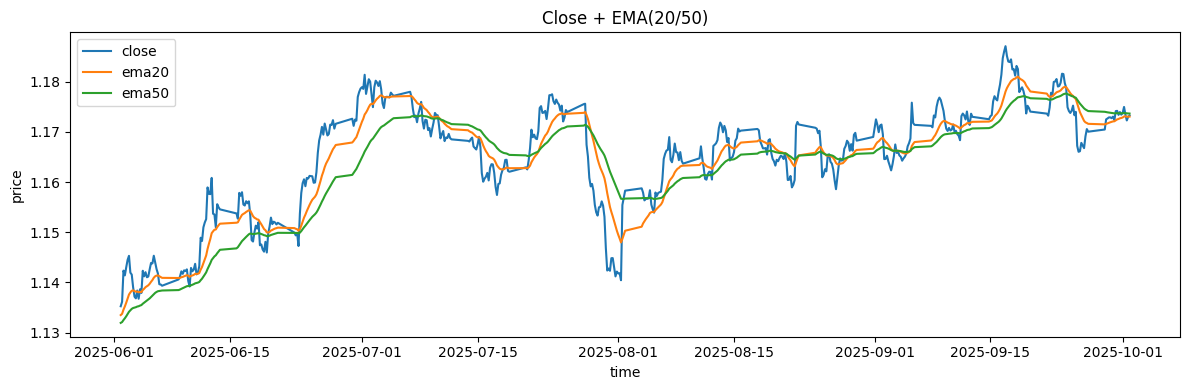

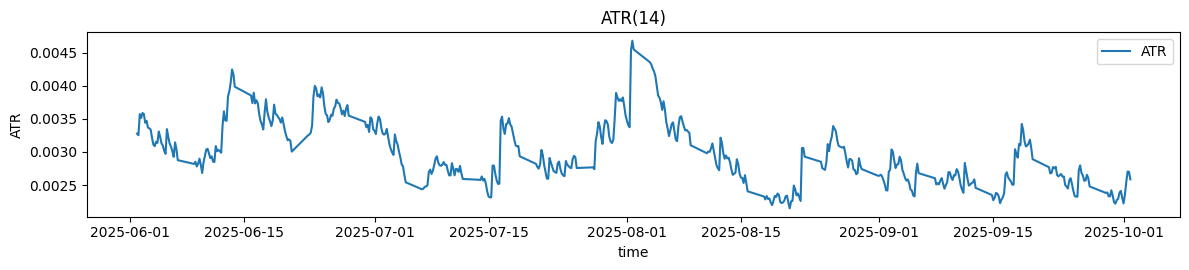

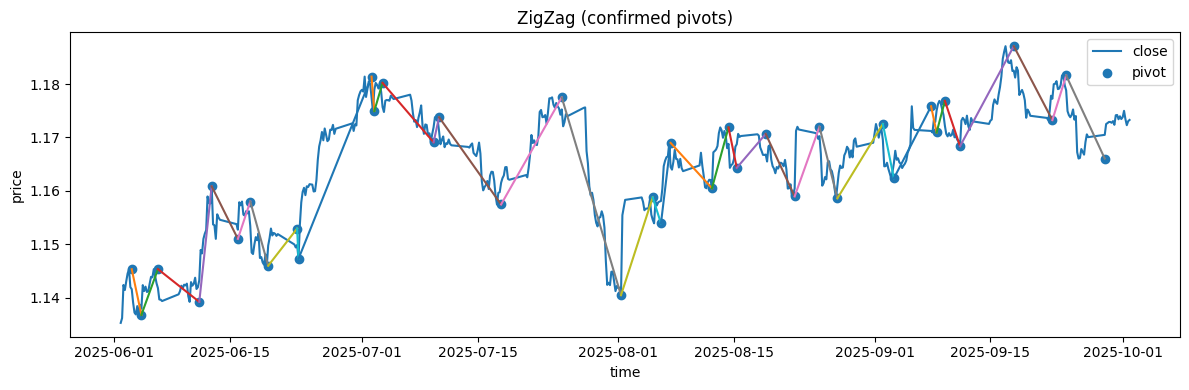

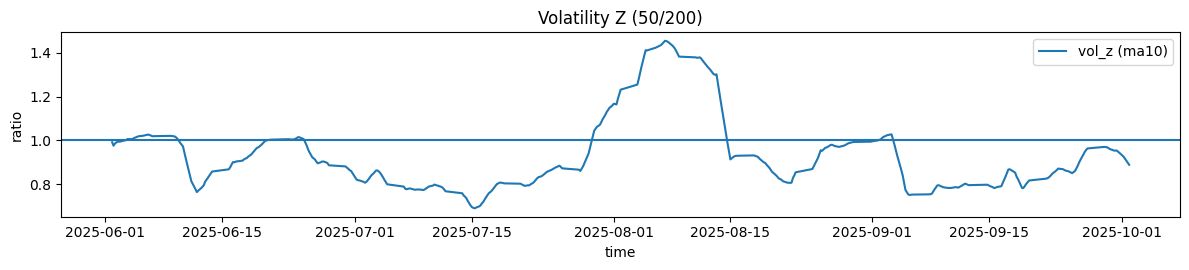

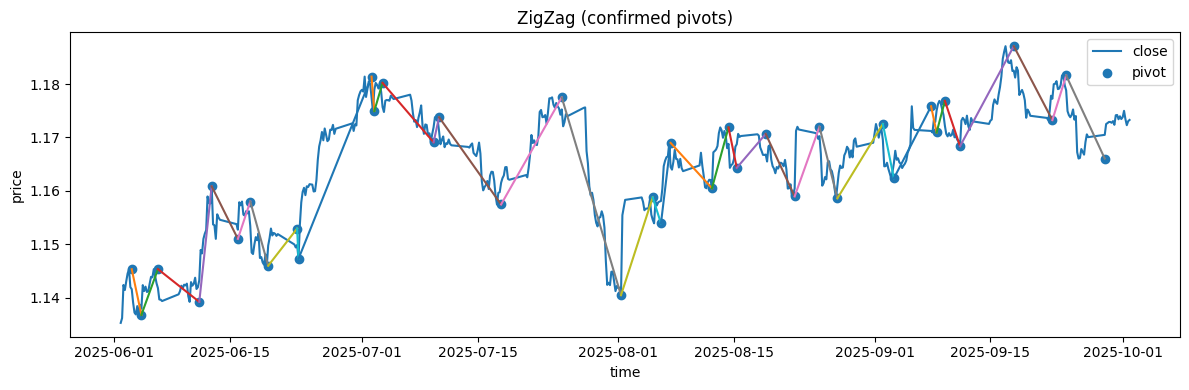

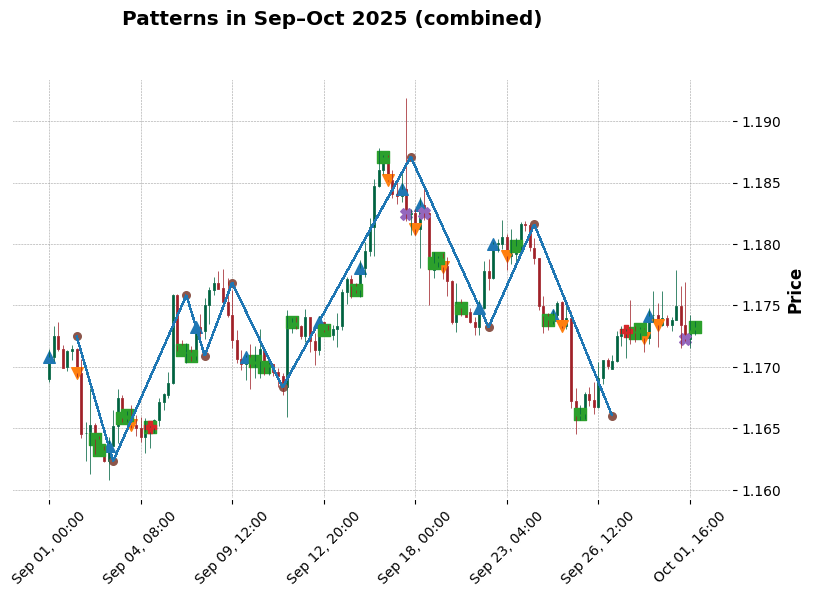

In [31]:
plot_close_with_emas_zoom(df, start="2025-06-01", end="2025-10-01", every=1)
plot_atr_zoom(df, start="2025-06-01", end="2025-10-01")
plot_zigzag_zoom(df, start="2025-06-01", end="2025-10-01")
plot_volz_zoom(df, start="2025-06-01", end="2025-10-01", smooth=10)

plot_zigzag_zoom(df, start="2025-06-01", end="2025-10-01")
# plot_candles_with_patterns_zoom(df, start="2025-09-01", end="2025-10-01",
#                                 title="Patterns in Sep–Oct 2025")
plot_candles_patterns_zigzag(
    df, start="2025-09-01", end="2025-10-01",
    title="Patterns in Sep–Oct 2025 (combined)"
)

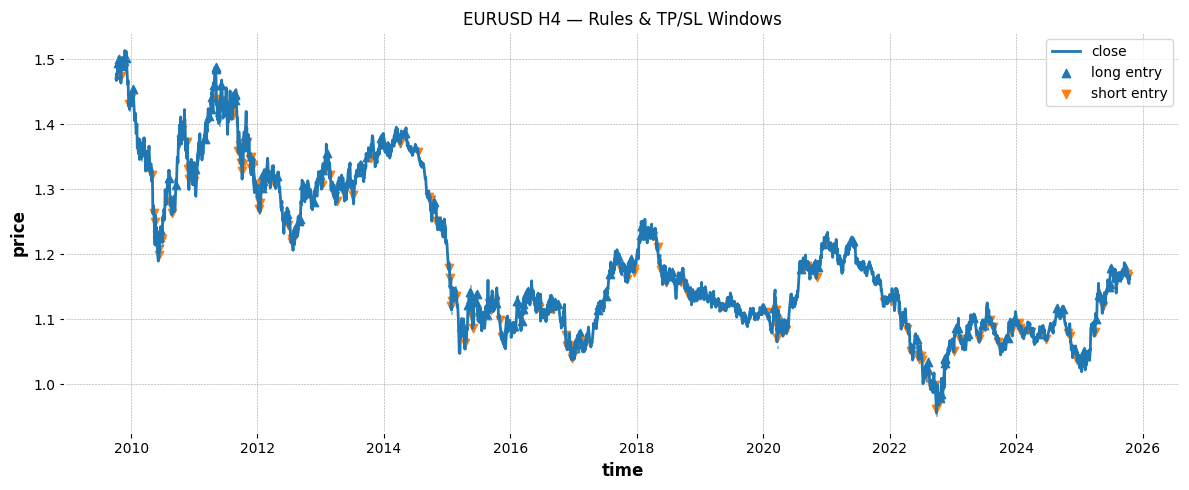

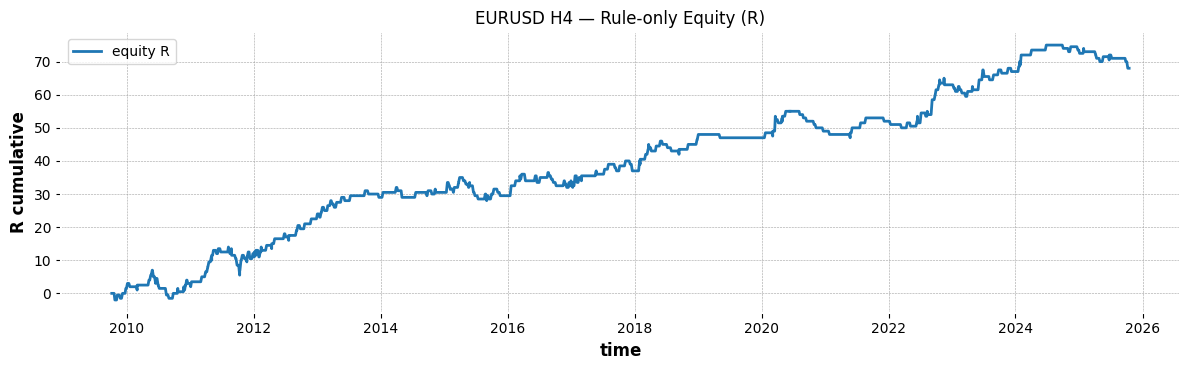

,trades,wins,losses,hit_rate,expectancy_R,RR_assumed
0,302,148,154,0.4901,0.2252,1.5


In [32]:
RR_TARGET = 1.5
ATR_MULT  = 1.0
K_BARS    = 12

plot_price_with_signals(df, k=K_BARS, rr=RR_TARGET, atr_mult=ATR_MULT,
                        title='EURUSD H4 — Rules & TP/SL Windows')

eq, smry = compute_r_multiple_series(df, rr=RR_TARGET)
plot_equity(eq, title='EURUSD H4 — Rule-only Equity (R)')

from IPython.display import display
display(smry)


- เส้นนั้นคือ Equity (หน่วย R) ของกติกาที่เราตั้ง (rule-only)
- R = ผล/ความเสี่ยงต่อไม้
  - ถ้า RR=1.5 แล้วไม้ชนะ ⇒ +1.5R
  - ไม้แพ้ ⇒ −1R

- เส้น “ขึ้น” แปลว่าได้ R สะสมเพิ่ม, “ลง” แปลว่าลดลง

>ดังนั้นกราฟนี้บอกว่า “กติกานี้เก็บ R ได้ประมาณ +70R ตลอดช่วงข้อมูล”
แต่ยัง ไม่ใช่เงิน เพราะยังไม่หักต้นทุน และยังไม่ได้คูณ “ความเสี่ยงต่อไม้” (เช่น 1% ของพอร์ต)

In [33]:
import pandas as pd

def ensure_datetime_index(df):
    d = df.copy()
    if 'datetime' in d.columns:
        d['datetime'] = pd.to_datetime(d['datetime'], errors='coerce')
        d = d.set_index('datetime')
    if not isinstance(d.index, pd.DatetimeIndex):
        d.index = pd.to_datetime(d.index, errors='coerce')
    d = d[~d.index.isna()].sort_index()
    d = d[~d.index.duplicated(keep='first')]
    return d


In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_price_with_signals_range(df, start=None, end=None, *,
    price_col='close', k=12, rr=1.5, atr_mult=1.0, title='Price & Signals'
):
    d = ensure_datetime_index(df)
    d = d.loc[str(start):str(end)] if (start or end) else d
    need = {'entry_long_rule','entry_short_rule','atr','high','low','close'}
    missing = need - set(d.columns)
    assert not missing, f"missing columns: {missing}"
    if d.empty:
        return None

    px = d[price_col]
    fig = plt.figure(figsize=(12,4.5))
    plt.plot(px.index, px.values, label='close')

    long_idx  = d.index[d['entry_long_rule']==1]
    short_idx = d.index[d['entry_short_rule']==1]
    plt.scatter(long_idx,  px.loc[long_idx],  marker='^', label='long entry')
    plt.scatter(short_idx, px.loc[short_idx], marker='v', label='short entry')

    # วาด TP/SL ช่วง k แท่ง
    for idx in long_idx:
        stop = atr_mult * d.at[idx, 'atr']
        if not np.isfinite(stop) or stop<=0: continue
        entry = d.at[idx, 'close']; tp = entry + rr*stop; sl = entry - stop
        i0 = d.index.get_loc(idx); i1 = min(i0 + k, len(d)-1)
        xs = d.index[i0:i1+1]
        plt.hlines([tp, sl], xs[0], xs[-1], linestyles='dotted')
    for idx in short_idx:
        stop = atr_mult * d.at[idx, 'atr']
        if not np.isfinite(stop) or stop<=0: continue
        entry = d.at[idx, 'close']; tp = entry - rr*stop; sl = entry + stop
        i0 = d.index.get_loc(idx); i1 = min(i0 + k, len(d)-1)
        xs = d.index[i0:i1+1]
        plt.hlines([tp, sl], xs[0], xs[-1], linestyles='dotted')

    plt.title(title); plt.xlabel('time'); plt.ylabel('price'); plt.legend(loc='best')
    plt.tight_layout()
    return fig  # คืน figure เพื่อให้ caller จะ save/show ได้


In [35]:
import os

def loop_year_month_plot(df, year_from=None, year_to=None, months=None, *,
                         k=12, rr=1.5, atr_mult=1.0,
                         save_dir=None, show=True):
    """
    - year_from/year_to: ถ้าไม่ระบุ จะใช้ min/max จากข้อมูล
    - months: รายการเดือนที่อยากวาด (1..12) ถ้าไม่ระบุ = ทั้งปี
    - save_dir: โฟลเดอร์สำหรับบันทึก PNG (ถ้า None จะไม่บันทึก)
    - show: True = แสดงบนจอ, False = แค่บันทึกไฟล์
    """
    d = ensure_datetime_index(df)
    yf = year_from or d.index.year.min()
    yt = year_to   or d.index.year.max()
    months = months or list(range(1,13))
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for y in range(yf, yt+1):
        for m in months:
            start = pd.Timestamp(year=y, month=m, day=1)
            end   = start + pd.offsets.MonthEnd(1)
            dm = d.loc[start:end]
            if dm.empty:
                continue
            title = f"{start:%Y-%m} — Rules & TP/SL Windows"
            fig = plot_price_with_signals_range(d, start, end,
                                                k=k, rr=rr, atr_mult=atr_mult,
                                                title=title)
            if fig is None:
                continue
            if save_dir:
                fp = os.path.join(save_dir, f"{start:%Y-%m}.png")
                fig.savefig(fp, dpi=120)
            if show:
                plt.show()
            else:
                plt.close(fig)


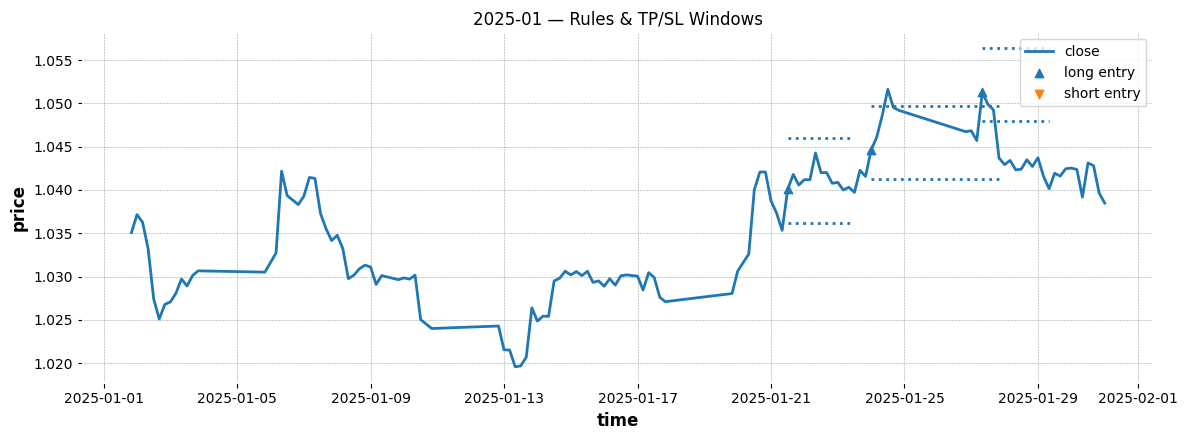

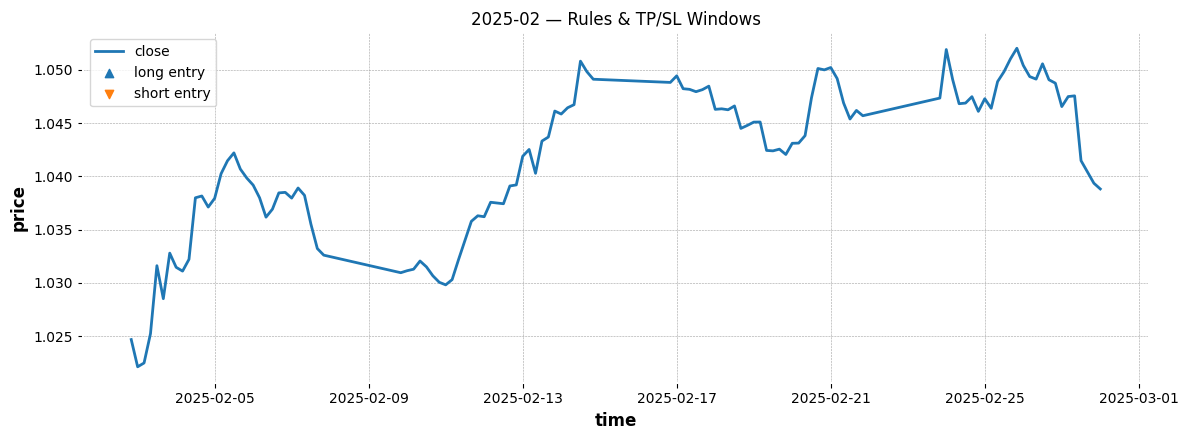

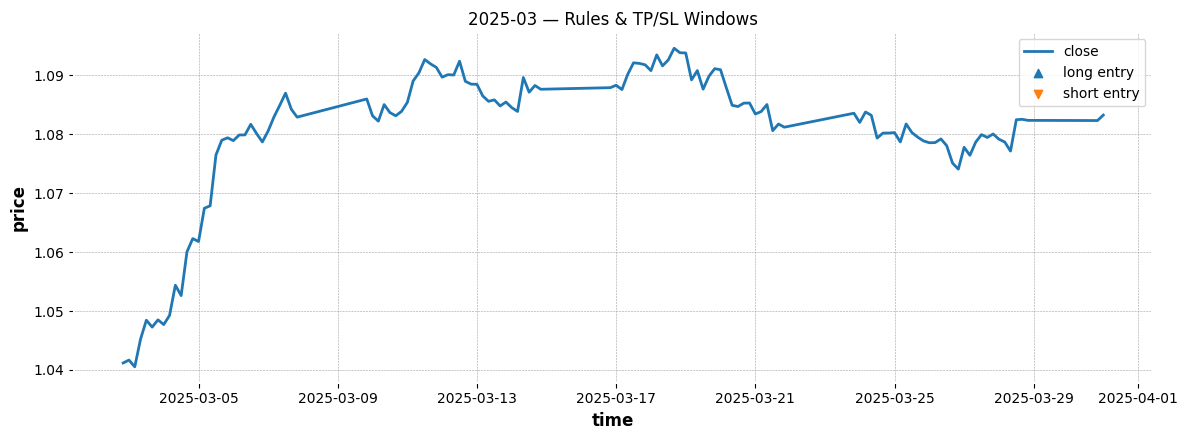

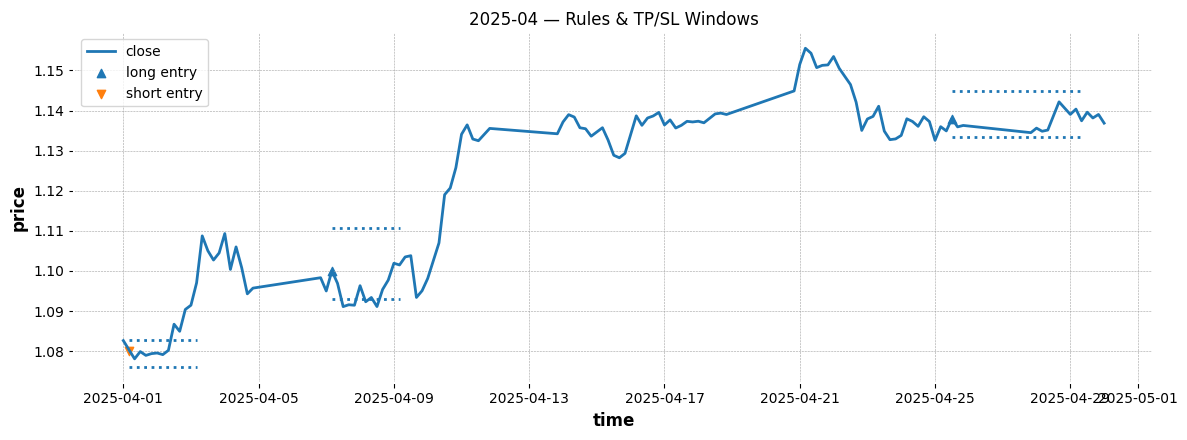

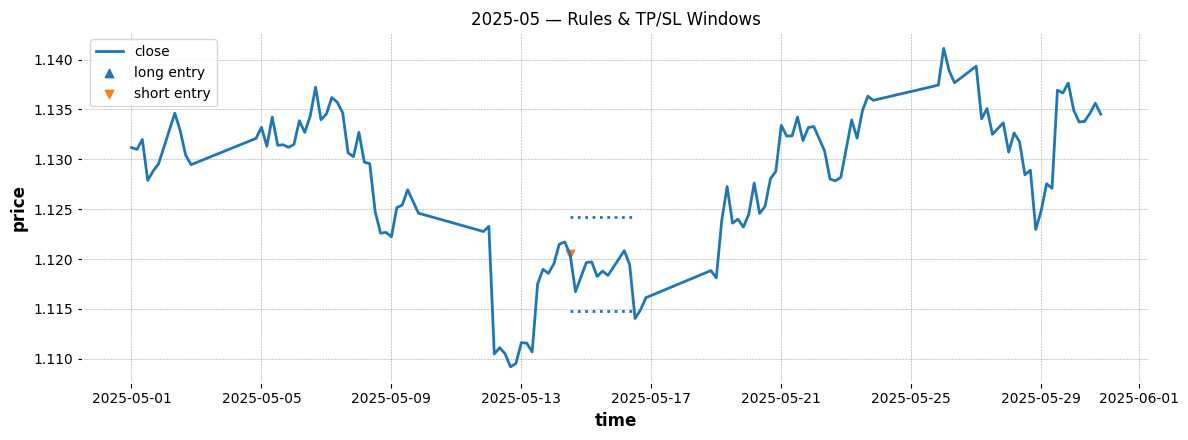

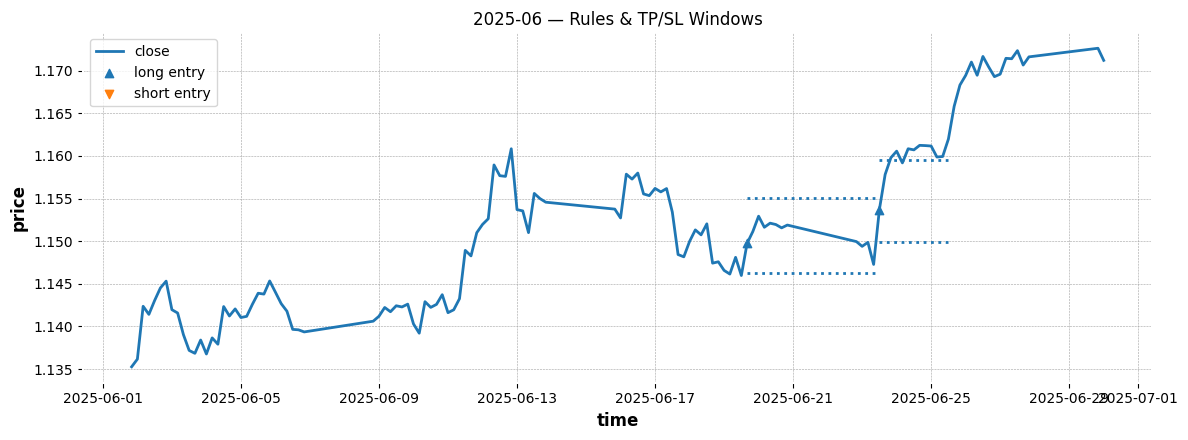

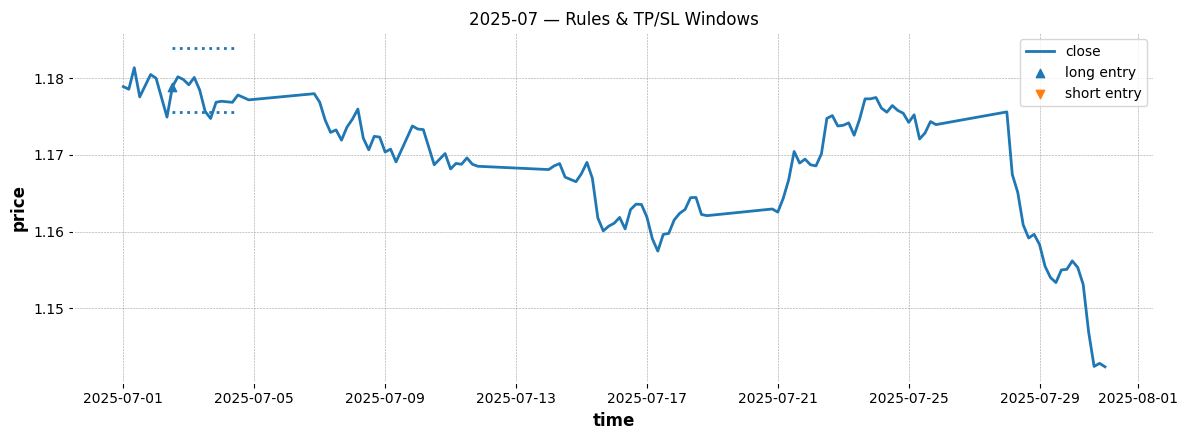

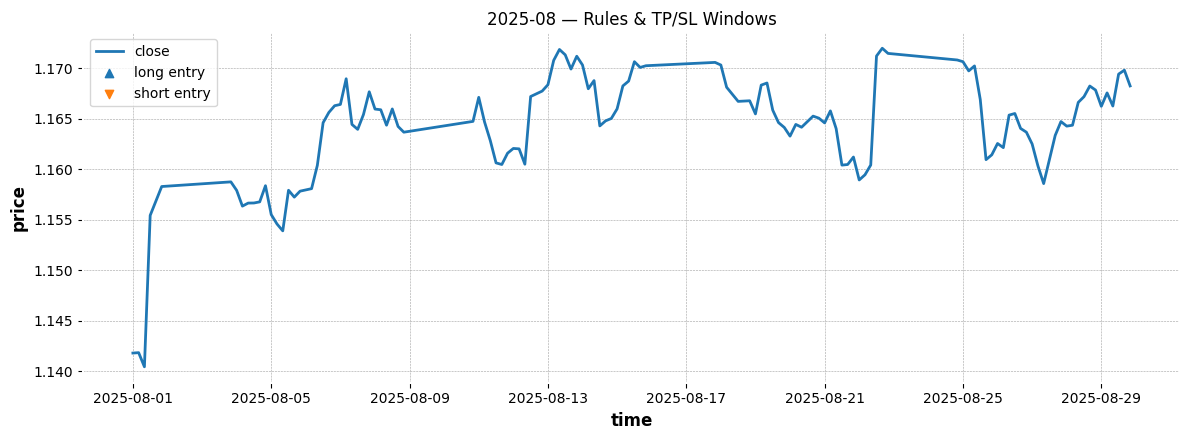

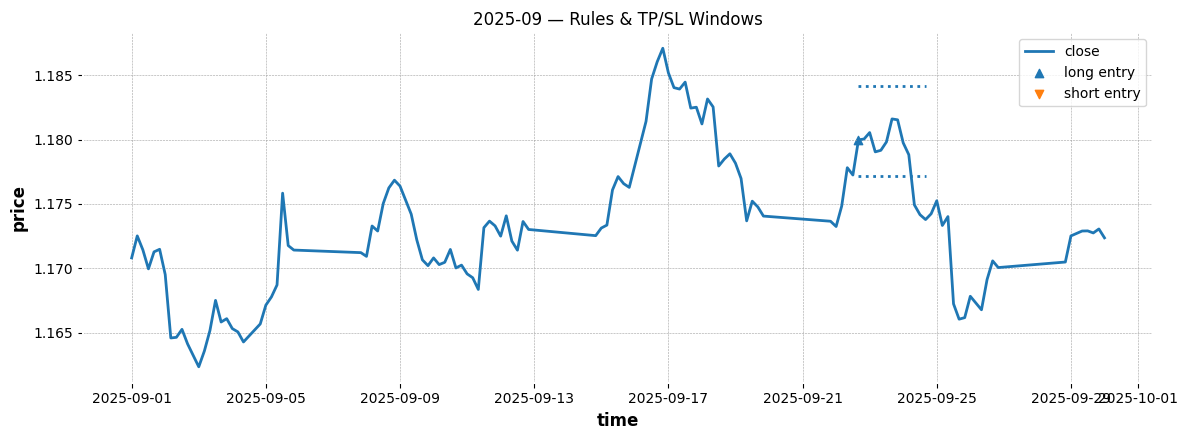

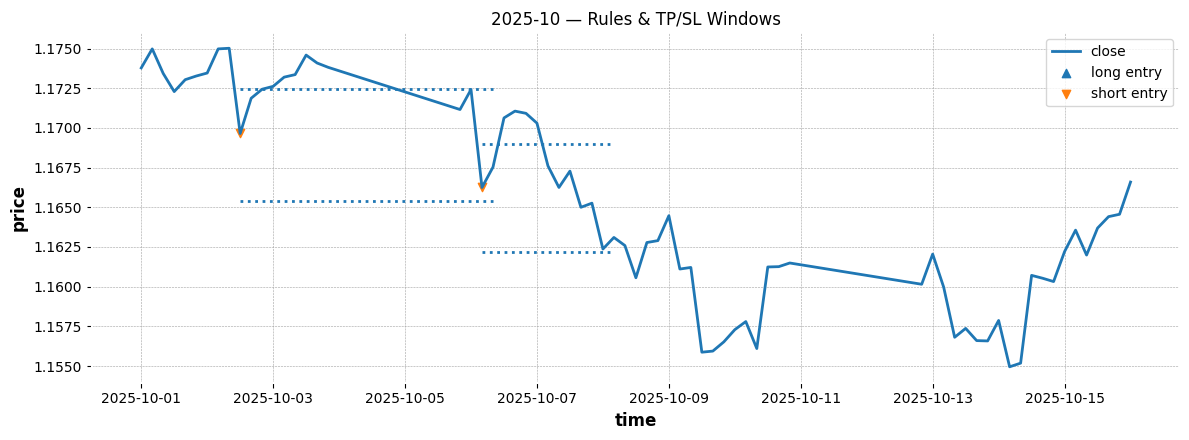

In [36]:
# วาดทุกเดือนของปี 2025 (แสดงบนจอ)
loop_year_month_plot(df, year_from=2025, year_to=2025,
                     k=K_BARS, rr=RR_TARGET, atr_mult=ATR_MULT,
                     show=True)

# วาด 2019-2020 เฉพาะเดือน 1,3,6 แล้วบันทึกเป็นไฟล์
# loop_year_month_plot(df, 2019, 2020, months=[1,3,6],
#                      k=K_BARS, rr=RR_TARGET, atr_mult=ATR_MULT,
#                      save_dir="/content/plots_monthly", show=False)


In [37]:
import numpy as np
import pandas as pd

# --- 1) ช่วยคำนวณคอนเท็กซ์ (regime & ทิศ)
def _classify_regime_row(row, vol_thresh=0.95, ema_gap_k=0.30):
    # range ถ้า vol ต่ำ และ EMA20-EMA50 ห่างไม่มากเมื่อเทียบกับ ATR
    ema_gap = abs(row['ema_fast'] - row['ema_slow'])
    cond_vol  = row.get('vol_z', 1.0) < vol_thresh
    cond_gap  = ema_gap <= ema_gap_k * row['atr'] if row['atr']>0 else True
    return 'range' if (cond_vol and cond_gap) else 'trend'

def _dir_ok(side, trend_up):
    return (side=='long' and trend_up==1) or (side=='short' and trend_up==0)

# --- 2) Log ทีละไม้ (สาเหตุ + ผลลัพธ์ + คอนเท็กซ์)
def make_entry_log_v2(df, rr=1.5, atr_mult=1.0, k=12,
                      vol_thresh=0.95, ema_gap_k=0.30):
    need = ['open','high','low','close','atr',
            'ema_fast','ema_slow','trend_up','vol_z',
            'entry_long_rule','entry_short_rule',
            'bull_engulf','bear_engulf','inside_bar','pin_bull','pin_bear',
            'near_pivot_low','near_pivot_high']
    d = df.copy()
    for c in need:
        if c not in d.columns: d[c] = 0

    rows = []
    highv = d['high'].values; lowv = d['low'].values; closev = d['close'].values; atrv = d['atr'].values
    n = len(d)

    for i, t in enumerate(d.index):
        for side in ('long','short'):
            if (side=='long' and d.at[t,'entry_long_rule']!=1) or (side=='short' and d.at[t,'entry_short_rule']!=1):
                continue

            entry = closev[i]; stop = atr_mult*atrv[i]
            if not np.isfinite(stop) or stop<=0:
                continue
            if side=='long':
                tp = entry + rr*stop; sl = entry - stop
            else:
                tp = entry - rr*stop; sl = entry + stop

            # สแกนข้างหน้าเพื่อดูอะไรโดนก่อน
            exit_time = pd.NaT; exit_px = np.nan; outcome = -1  # -1=no event
            j_end = min(n-1, i+k)
            for j in range(i+1, j_end+1):
                if side=='long':
                    if highv[j] >= tp: outcome=1; exit_time=d.index[j]; exit_px=tp; break
                    if lowv[j]  <= sl: outcome=0; exit_time=d.index[j]; exit_px=sl; break
                else:
                    if lowv[j]  <= tp: outcome=1; exit_time=d.index[j]; exit_px=tp; break
                    if highv[j] >= sl: outcome=0; exit_time=d.index[j]; exit_px=sl; break

            # คอนเท็กซ์
            regime = _classify_regime_row(d.iloc[i], vol_thresh=vol_thresh, ema_gap_k=ema_gap_k)
            dir_match = _dir_ok(side, int(d.at[t,'trend_up']))
            reason = []
            if side=='long':
                if d.at[t,'bull_engulf']==1: reason.append('bull_engulf')
                if d.at[t,'pin_bull']==1:    reason.append('pin_bull')
                if d.at[t,'inside_bar']==1:  reason.append('inside_bar')
                if d.at[t,'near_pivot_low']==1:  reason.append('near_pivot_low')
            else:
                if d.at[t,'bear_engulf']==1: reason.append('bear_engulf')
                if d.at[t,'pin_bear']==1:    reason.append('pin_bear')
                if d.at[t,'inside_bar']==1:  reason.append('inside_bar')
                if d.at[t,'near_pivot_high']==1: reason.append('near_pivot_high')

            rows.append({
                'time': t, 'side': side, 'entry_px': entry, 'tp': tp, 'sl': sl,
                'exit_time': exit_time, 'exit_px': exit_px, 'outcome': outcome,  # 1/0/-1
                'rr_target': rr, 'atr_mult': atr_mult, 'window_bars': k,
                'trend_up': int(d.at[t,'trend_up']), 'vol_z': float(d.at[t,'vol_z']),
                'ema_gap': float(abs(d.at[t,'ema_fast']-d.at[t,'ema_slow'])),
                'atr': float(d.at[t,'atr']), 'regime': regime, 'dir_ok': int(dir_match),
                'reason': '+'.join(reason) if reason else f'rule_{side}'
            })

    log = pd.DataFrame(rows).sort_values('time').reset_index(drop=True)
    return log

# --- 3) สรุปปัญหา “เข้าในตลาดแคบ/ทิศผิด” เป็นตาราง
def analyze_entry_log(log):
    if log.empty:
        return log, pd.DataFrame(), pd.DataFrame()

    # เฉพาะไม้ที่มีเหตุการณ์ (tp/sl)
    log_eff = log[log['outcome'].isin([0,1])].copy()
    # label ปัญหา
    log_eff['is_range'] = (log_eff['regime']=='range').astype(int)
    log_eff['dir_mismatch'] = (log_eff['dir_ok']==0).astype(int)

    # สรุปกลุ่ม
    by_regime = (log_eff
                 .groupby('regime')['outcome']
                 .value_counts()
                 .unstack(fill_value=0)
                 .rename(columns={0:'losses',1:'wins'}))
    by_dir = (log_eff
              .groupby('dir_ok')['outcome']
              .value_counts()
              .unstack(fill_value=0)
              .rename(index={0:'mismatch',1:'aligned'})
              .rename(columns={0:'losses',1:'wins'}))

    return log_eff, by_regime, by_dir


In [38]:
# ทำ log ทั้งหมดครั้งเดียว
LOG = make_entry_log_v2(df, rr=RR_TARGET, atr_mult=ATR_MULT, k=K_BARS,
                        vol_thresh=0.95, ema_gap_k=0.30)

# เลือกดูเฉพาะช่วงที่พล็อต (เช่น 2025-01, 2025-02, 2025-04)
log_2025_01 = LOG[LOG['time'].between('2025-01-01', '2025-01-31 23:59')]
log_2025_02 = LOG[LOG['time'].between('2025-02-01', '2025-02-28 23:59')]
log_2025_04 = LOG[LOG['time'].between('2025-04-01', '2025-04-30 23:59')]

# แสดงหัวข้อ log (เลือกคอลัมน์สำคัญ)
cols = ['time','side','entry_px','outcome','regime','dir_ok','vol_z','ema_gap','atr','reason','exit_time']
display(log_2025_01[cols].head(50))
display(log_2025_02[cols].head(50))
display(log_2025_04[cols].head(50))

# สรุปว่าแพ้เพราะ range/เพราะทิศผิดมากแค่ไหน
log_eff, by_regime, by_dir = analyze_entry_log(LOG)
display(by_regime)
display(by_dir)


,time,side,entry_px,outcome,regime,dir_ok,vol_z,ema_gap,atr,reason,exit_time
297,2025-01-21 12:00:00,long,1.04006,-1,trend,1,1.035126,0.002275,0.003929,bull_engulf+near_pivot_low,NaT
298,2025-01-24 00:00:00,long,1.04460,1,trend,1,0.937076,0.003649,0.003371,bull_engulf+near_pivot_low,2025-01-24 08:00:00
299,2025-01-27 08:00:00,long,1.05129,0,trend,1,1.011216,0.004986,0.003381,bull_engulf+near_pivot_low,2025-01-27 20:00:00


,time,side,entry_px,outcome,regime,dir_ok,vol_z,ema_gap,atr,reason,exit_time


,time,side,entry_px,outcome,regime,dir_ok,vol_z,ema_gap,atr,reason,exit_time
300,2025-04-01 04:00:00,short,1.08016,0,range,1,0.879548,0.000446,0.002697,bear_engulf+near_pivot_high,2025-04-01 08:00:00
301,2025-04-07 04:00:00,long,1.10003,0,trend,1,1.346963,0.005866,0.007116,bull_engulf+near_pivot_low,2025-04-07 12:00:00
302,2025-04-25 12:00:00,long,1.13800,0,trend,1,0.934377,0.001756,0.004658,bull_engulf+near_pivot_low,2025-04-28 04:00:00


outcome,losses,wins
regime,,
range,12,18
trend,142,130


outcome,losses,wins
dir_ok,,
aligned,154,148


In [39]:
EXPLAIN_COLS = [
    'bull_engulf','bear_engulf','inside_bar','pin_bull','pin_bear',
    'near_pivot_low','near_pivot_high','trend_up','vol_z','atr','zz_pivot'
]

def explain_entries(df, k=12, rr=1.5, atr_mult=1.0):
    rows = []
    for t in df.index[(df['entry_long_rule']==1) | (df['entry_short_rule']==1)]:
        side = 'long' if df.at[t,'entry_long_rule']==1 else 'short'
        stop = atr_mult*df.at[t,'atr']; entry = df.at[t,'close']
        tp = entry + rr*stop if side=='long' else entry - rr*stop
        sl = entry - stop     if side=='long' else entry + stop
        sub = df.loc[t:].iloc[1:k+1]
        # เหตุการณ์
        outcome, reason = -1, []
        if side=='long':
            if (sub['high']>=tp).any() and (sub['low']<=sl).any():
                # ดูว่าแท่งไหนชนก่อน
                j_tp = sub.index.get_indexer_for(sub.index[sub['high']>=tp])[:1]
                j_sl = sub.index.get_indexer_for(sub.index[sub['low']<=sl])[:1]
                outcome = int((len(j_tp)>0) and (len(j_sl)>0) and (j_tp[0] < j_sl[0]))
                if outcome==0: outcome=0
                elif outcome==1: outcome=1
            elif (sub['high']>=tp).any(): outcome=1
            elif (sub['low']<=sl).any(): outcome=0
        else:
            if (sub['low']<=tp).any() and (sub['high']>=sl).any():
                j_tp = sub.index.get_indexer_for(sub.index[sub['low']<=tp])[:1]
                j_sl = sub.index.get_indexer_for(sub.index[sub['high']>=sl])[:1]
                outcome = int((len(j_tp)>0) and (len(j_sl)>0) and (j_tp[0] < j_sl[0]))
            elif (sub['low']<=tp).any(): outcome=1
            elif (sub['high']>=sl).any(): outcome=0

        # สรุปเหตุผล
        for c in EXPLAIN_COLS:
            if c in df.columns and df.at[t, c]==1:
                reason.append(c)
        rows.append({
            'time': t, 'side': side, 'entry': entry, 'tp':tp, 'sl':sl,
            'outcome': outcome, 'reasons': '+'.join(reason) if reason else 'rule_only',
            'trend_up': int(df.at[t,'trend_up']), 'vol_z': float(df.at[t,'vol_z'])
        })
    return pd.DataFrame(rows).sort_values('time')

entry_log_simple = explain_entries(df, k=K_BARS, rr=RR_TARGET, atr_mult=ATR_MULT)
display(entry_log_simple.head(20))


,time,side,entry,tp,sl,outcome,reasons,trend_up,vol_z
0,2009-10-19 12:00:00,long,1.49434,1.502093,1.489171,0,bull_engulf+near_pivot_low+trend_up,1,NaN
1,2009-10-21 12:00:00,long,1.50067,1.508712,1.495309,0,bull_engulf+near_pivot_low+trend_up,1,NaN
2,2009-11-02 16:00:00,short,1.47498,1.465668,1.481188,1,bear_engulf+near_pivot_high,0,NaN
3,2009-11-18 12:00:00,long,1.49677,1.504771,1.491436,0,pin_bull+near_pivot_low+trend_up,1,NaN
4,2009-12-01 04:00:00,long,1.50267,1.511681,1.496663,1,pin_bull+near_pivot_low+trend_up,1,1.070635
5,2009-12-21 12:00:00,short,1.43119,1.422376,1.437066,1,bear_engulf+near_pivot_high+zz_pivot,0,1.097802
6,2009-12-29 12:00:00,short,1.44046,1.434655,1.444330,1,bear_engulf+near_pivot_high+zz_pivot,0,0.844078
7,2010-01-12 12:00:00,long,1.45379,1.462347,1.448085,0,bull_engulf+near_pivot_low+trend_up,1,0.921487
8,2010-02-24 16:00:00,short,1.35250,1.342956,1.358863,0,bear_engulf+near_pivot_low+near_pivot_high,0,1.250432
9,2010-03-01 08:00:00,short,1.35421,1.344541,1.360656,1,bear_engulf+near_pivot_high,0,1.299184
